In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kevandong","key":"c7ea20330645c70af3ad4bf050e88abf"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle
!kaggle --version

Kaggle API 1.6.17


In [ ]:
!kaggle competitions download -c deep-learning-spring-2025-project-1
!unzip -q deep-learning-spring-2025-project-1.zip -d ./data

deep-learning-spring-2025-project-1.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ./data/cifar-10-python/cifar-10-batches-py/batches.meta? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar-10-python/cifar-10-batches-py/data_batch_1? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar-10-python/cifar-10-batches-py/data_batch_2? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar-10-python/cifar-10-batches-py/data_batch_3? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar-10-python/cifar-10-batches-py/data_batch_4? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar-10-python/cifar-10-batches-py/data_batch_5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar-10-python/cifar-10-batches-py/readme.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar-10-python/cifar-10-batches-py/test_batch? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar_test_nolabel.pkl? [

In [ ]:
# import pickle
# import numpy as np

# def unpickle(file):
#   import pickle
#   with open(file, 'rb') as fo:
#     dict = pickle.load(fo, encoding='bytes')
#   return dict

# batch_files = [
#     './data/cifar-10-python/cifar-10-batches-py/data_batch_1',
#     './data/cifar-10-python/cifar-10-batches-py/data_batch_2',
#     './data/cifar-10-python/cifar-10-batches-py/data_batch_3',
#     './data/cifar-10-python/cifar-10-batches-py/data_batch_4',
#     './data/cifar-10-python/cifar-10-batches-py/data_batch_5'
# ]

# test_file = './data/cifar-10-python/cifar-10-batches-py/test_batch'

# train_data = []
# train_labels = []
# test_data = []
# test_labels = []

# for file in batch_files:
#     batch = unpickle(file)
#     train_data.append(batch[b'data'])
#     train_labels.extend(batch[b'labels'])

# test_batch = unpickle(test_file)
# test_data.append(test_batch[b'data'])
# test_labels.extend(test_batch[b'labels'])

# train_data = np.concatenate(train_data, axis=0)
# train_labels = np.array(train_labels)
# train_data = train_data.reshape(-1, 3, 32, 32)
# test_data = np.array(test_data)
# test_labels = np.array(test_labels)
# test_data = test_data.reshape(-1, 3, 32, 32)
# print(f'Training data shape: {train_data.shape}')
# print(f'Training labels shape: {train_labels.shape}')
# print(f'Testing data shape: {test_data.shape}')
# print(f'Testing labels shape: {test_labels.shape}')

Training data shape: (50000, 3, 32, 32)
Training labels shape: (50000,)
Testing data shape: (10000, 3, 32, 32)
Testing labels shape: (10000,)


In [ ]:
from data_handler import DataHandler
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# 数据集类
class CIFAR10Dataset(Dataset):
    def __init__(self, data_handler, files, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        for file in files:
            batch = data_handler.unpickle(file)
            images = batch[b"data"].reshape(-1, 3, 32, 32).astype(np.uint8)
            labels = batch[b"labels"]
            self.data.append(images)
            self.labels.extend(labels)

        self.data = np.vstack(self.data)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        image = np.transpose(image, (1, 2, 0))
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
        # 数据处理

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

data_handler = DataHandler("./data/cifar-10-python/cifar-10-batches-py/")
train_files = [f"data_batch_{i}" for i in range(1, 6)]
test_files = ["test_batch"]

train_dataset = CIFAR10Dataset(data_handler, train_files, transform=transform)
test_dataset = CIFAR10Dataset(data_handler, test_files, transform=transform)

trainDataLoader = DataLoader(train_dataset, batch_size=128, shuffle=True)
testDataLoader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
# import torch
# from torch.utils.data import TensorDataset, DataLoader

# train_data = torch.tensor(train_data, dtype=torch.float32)
# train_labels = torch.tensor(train_labels, dtype=torch.long)

# test_data = torch.tensor(test_data, dtype=torch.float32)
# test_labels = torch.tensor(test_labels, dtype=torch.long)

# train_dataset = TensorDataset(train_data, train_labels)
# test_dataset = TensorDataset(test_data, test_labels)

# trainDataLoader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# testDataLoader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()
    # Using 3x3 square kernel, padding=1 ensure that the output size is the same as the input size.
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.sample = None
    if stride != 1 or in_channels != out_channels:
      self.sample = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels)
            )
  def forward(self, x):
    residualx = x
    if self.sample is not None:
      residualx = self.sample(x)

    out = self.conv1(x)
    out = self.bn1(out)
    out = nn.ReLU(inplace=True)(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out += residualx
    out = nn.ReLU(inplace=True)(out)

    return out

In [ ]:
class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes = 10):
     super(ResNet, self).__init__()
     self.in_channels = 42

     self.conv1 = nn.Conv2d(3, 42, kernel_size=3, stride=1, padding=1, bias=False)
     self.bn1 = nn.BatchNorm2d(42)
     self.relu = nn.ReLU(inplace=True)
     self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

     self.layer1 = self._make_layer(block, 42, layers[0])
     self.layer2 = self._make_layer(block, 84, layers[1], stride=2)
     self.layer3 = self._make_layer(block, 168, layers[2], stride=2)
     self.layer4 = self._make_layer(block, 336, layers[3], stride=2)

     self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
     self.fc = nn.Linear(336, num_classes)

    #  self.in_channels = 64
    #  self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    #  self.bn1 = nn.BatchNorm2d(64)
    #  self.relu = nn.ReLU(inplace=True)
    #  self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    #  self.layer1 = self._make_layer(block, 64, layers[0])
    #  self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
    #  self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
    #  self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

    #  self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    #  self.fc = nn.Linear(512, num_classes)



  def _make_layer(self, block, out_channels, blocks, stride=1):
     layers = [block(self.in_channels, out_channels, stride)]
     self.in_channels = out_channels
     layers += [block(out_channels, out_channels) for _ in range(1, blocks)]
     return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)

    return x

layers = [2, 2, 2, 2]
model = ResNet(ResidualBlock, layers).cuda()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
print(model)

ResNet(
  (conv1): Conv2d(3, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1

In [ ]:
!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 42, 224, 224]           1,134
       BatchNorm2d-2         [-1, 42, 224, 224]              84
              ReLU-3         [-1, 42, 224, 224]               0
         MaxPool2d-4         [-1, 42, 112, 112]               0
            Conv2d-5         [-1, 42, 112, 112]          15,876
       BatchNorm2d-6         [-1, 42, 112, 112]              84
            Conv2d-7         [-1, 42, 112, 112]          15,876
       BatchNorm2d-8         [-1, 42, 112, 112]              84
     ResidualBlock-9         [-1, 42, 112, 112]               0
           Conv2d-10         [-1, 42, 112, 112]          15,876
      BatchNorm2d-11         [-1, 42, 112, 112]              84
           Conv2d-12         [-1, 42, 112, 112]          15,876
      BatchNorm2d-13         [-1, 42, 112, 112]              84
    ResidualBlock-14         [-1, 42, 1

In [ ]:
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(100):
  train_loss = 0.0
  test_loss = 0.0
  correct_train = 0
  total_train = 0
  correct_test = 0
  total_test = 0

  model.train()
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = model(images) # forward propagation
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()

    _, predicted = torch.max(predicted_output, 1)  # Get class index with highest probability
    correct_train += (predicted == labels).sum().item()
    total_train += labels.size(0)

  model.eval()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      # if(i == 0):
      #   print(images[0])
      #   print(images.shape)
      #   print(images.type)
      #   print(images.device)
      #   print(images.min(), images.max())
      #   print(images.mean(), images.std())
      predicted_output = model(images)
      fit = loss(predicted_output, labels)
      test_loss += fit.item()

      _, predicted = torch.max(predicted_output, 1)  # Get class index with highest probability
      correct_test += (predicted == labels).sum().item()
      total_test += labels.size(0)

  train_loss = train_loss / len(trainDataLoader)
  test_loss = test_loss / len(testDataLoader)

  train_accuracy = correct_train / total_train
  test_accuracy = correct_test / total_test

  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  train_accuracy_history += [train_accuracy]
  test_accuracy_history += [test_accuracy]
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}, Train Accuracy {train_accuracy}, Test Accuracy {test_accuracy}')

Epoch 0, Train loss 1.3920236464656528, Test loss 1.1388383930242514, Train Accuracy 0.49508, Test Accuracy 0.594
Epoch 1, Train loss 1.000889983628412, Test loss 0.9382469842705545, Train Accuracy 0.64398, Test Accuracy 0.6676
Epoch 2, Train loss 0.8368832613805981, Test loss 0.8062451798704606, Train Accuracy 0.709, Test Accuracy 0.7107
Epoch 3, Train loss 0.7324760090512084, Test loss 0.8068364511562299, Train Accuracy 0.74434, Test Accuracy 0.7214
Epoch 4, Train loss 0.6555436238303514, Test loss 0.6837033701093891, Train Accuracy 0.77328, Test Accuracy 0.7659
Epoch 5, Train loss 0.6033098465951202, Test loss 0.6227041490470306, Train Accuracy 0.79218, Test Accuracy 0.7859
Epoch 6, Train loss 0.5599411418828208, Test loss 0.6900903171376337, Train Accuracy 0.8095, Test Accuracy 0.7651
Epoch 7, Train loss 0.5261436793048059, Test loss 0.5704027655758436, Train Accuracy 0.81966, Test Accuracy 0.8034
Epoch 8, Train loss 0.5008445843253904, Test loss 0.574352358904066, Train Accuracy 0

Base model with data augmentation. Train Accuracy: 0.9459, Test Accuracy: 0.8691. Epoch:100 Learning Rate: 0.001 Optimizer: Adam Augmentation used.

Base model without data augmentation. Train Accuracy: 0.9846, Test Accuracy: 0.7976. Epoch: 100 Learning Rate: 0.001 Optimizer: Adam. No augmentation.

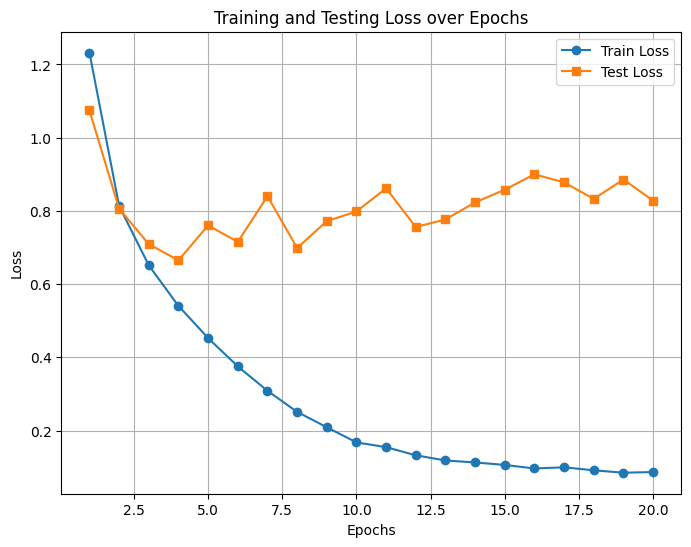

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_loss_history) + 1))


plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_history, label="Train Loss", marker="o")
plt.plot(epochs, test_loss_history, label="Test Loss", marker="s")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss over Epochs")
plt.legend()
plt.grid(True)

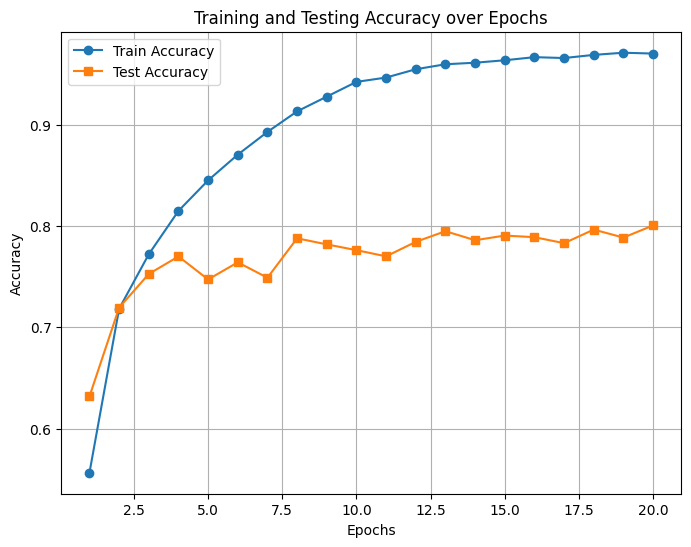

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy_history, label="Train Accuracy", marker="o")
plt.plot(epochs, test_accuracy_history, label="Test Accuracy", marker="s")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.legend()
plt.grid(True)

In [ ]:
import pickle
import torch
import pandas as pd

with open('./data/cifar_test_nolabel.pkl', 'rb') as f:
    data = pickle.load(f)

print(f"Data type: {type(data)}")

images = data[b'data'].transpose(0, 3, 1, 2)
ids = data[b'ids']
images = torch.from_numpy(images).float().cuda()

image_tensor = images[0]
print(image_tensor)

model.eval()
with torch.no_grad():
    # print(images.shape)
    # print(images.type)
    # print(images.device)
    # print(images.min(), images.max())
    # print(images.mean(), images.std())
    predicted_output = model(images)
    _, predictions = torch.max(predicted_output, 1)

df = pd.DataFrame({
    'ID': ids,
    'Predicted_Label': predictions.cpu().numpy()
})

csv_file = 'predictions.csv'
df.to_csv(csv_file, index=False)

print(f"Predictions saved to {csv_file}")

Data type: <class 'dict'>
tensor([[[ 19.,   1.,   1.,  ...,   1.,  18.,   0.],
         [  0.,  18.,   0.,  ..., 105., 103., 114.],
         [106., 104.,  87.,  ..., 107.,  99.,  97.],
         ...,
         [  1.,   0.,  14.,  ...,  12.,   2.,   1.],
         [ 21.,   2.,   1.,  ..., 149., 166., 169.],
         [145., 117., 113.,  ...,   6.,   6.,  14.]],

        [[  1.,   0.,  15.,  ...,  12.,   2.,   1.],
         [ 19.,   1.,   0.,  ..., 138., 152., 168.],
         [160., 166., 172.,  ...,  19.,  18.,  15.],
         ...,
         [179., 143., 167.,  ..., 101.,  74.,  61.],
         [ 57.,  44.,  98.,  ...,  22.,  10.,   5.],
         [ 27.,  19.,   6.,  ..., 182., 167., 186.]],

        [[185., 168., 188.,  ..., 126.,  97.,  82.],
         [ 77.,  60.,  57.,  ..., 126., 123., 109.],
         [ 24.,  15.,   9.,  ..., 155., 155., 168.],
         ...,
         [ 93.,  92.,  46.,  ...,  47., 103., 100.],
         [ 53.,  95.,  93.,  ...,  74.,  41.,  42.],
         [ 36.,  15.,  43.,

In [ ]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image

data = unpickle(test_file)

print(f"Data type: {type(data)}")

images = data[b'data'].transpose(0, 3, 1, 2)
ids = data[b'labels']
images = torch.from_numpy(images).float().cuda()

with open('./data/cifar-10-python/cifar-10-batches-py/batches.meta', 'rb') as f:
    meta = pickle.load(f, encoding='bytes')
label_names = [name.decode('utf-8') for name in meta[b'label_names']]

num_images = 25
selected_images = images[:num_images]
selected_labels = ids[:num_images]


model.eval()
with torch.no_grad():
    outputs = model(selected_images)
    _, predicted_labels = torch.max(outputs, 1)
predicted_labels = predicted_labels.cpu().numpy()

fig, axes = plt.subplots(5, 5, figsize=(10, 10))


for i, ax in enumerate(axes.flat):
    img = selected_images[i].cpu().numpy()
    img = img.transpose(1, 2, 0)
    img = img.astype(np.uint8)
    true_label = label_names[selected_labels[i]]
    pred_label = label_names[predicted_labels[i]]

    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color="green" if true_label == pred_label else "red")
    ax.axis("off")

plt.tight_layout()
plt.show()


Data type: <class 'dict'>


ValueError: axes don't match array

(10000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


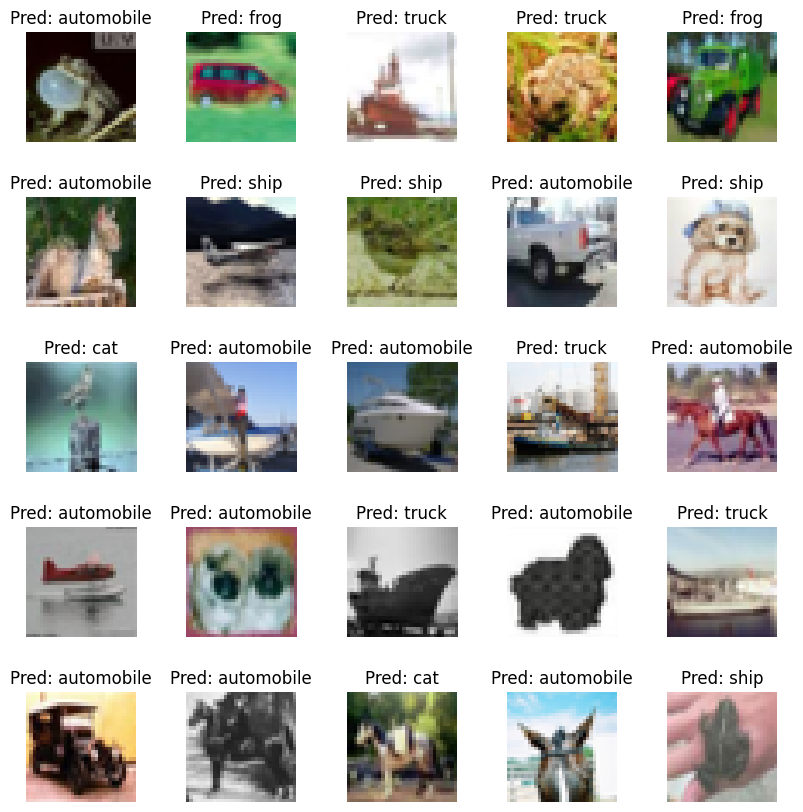

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
if __name__ == '__main__':
    with open('./data/cifar_test_nolabel.pkl', 'rb') as f:
      data = pickle.load(f)

    nolable_images = data[b'data']
    nolable_id = data[b'ids']
    print(nolable_images.shape)


    # 读取预测结果
    predictions_df = pd.read_csv("predictions.csv")

    # 读取无标签数据
    nolabel_images = nolable_images.transpose(0, 3, 1, 2).astype(np.uint8)  # 变换为 (batch, channels, height, width)

    # 读取 CIFAR-10 类别名称
    # data_handler = DataHandler("./cifar-10-python/cifar-10-batches-py/")
    # meta_data = data_handler.unpickle("batches.meta")
    # label_names = [name.decode("utf-8") for name in meta_data[b"label_names"]]  # 解码类别名称
    with open('./data/cifar-10-python/cifar-10-batches-py/batches.meta', 'rb') as f:
      meta = pickle.load(f, encoding='bytes')
    label_names = [name.decode('utf-8') for name in meta[b'label_names']]

    print(label_names)

    # 选择前 25 张图片
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # 创建 5x5 子图
    fig.subplots_adjust(hspace=0.5)  # 调整子图间距

    for i, ax in enumerate(axes.flat):
        if i >= len(predictions_df):  # 避免索引超出范围
            break

        img_id = predictions_df.iloc[i, 0]  # 获取 ID
        predicted_label = predictions_df.iloc[i, 1]  # 获取预测标签索引
        predicted_class = label_names[predicted_label]  # 获取类别名称

        image = nolabel_images[img_id].transpose(1, 2, 0)  # 变换为 (H, W, C)

        ax.imshow(image)
        ax.set_title(f"Pred: {predicted_class}")  # 显示预测类别
        ax.axis("off")  # 关闭坐标轴

    # 显示图像
    plt.show()



In [ ]:
import pandas as pd
file1 = 'predictions_1.csv'
file2 = 'predictions_2.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

df1 = df1.sort_values(by='ID').reset_index(drop=True)
df2 = df2.sort_values(by='ID').reset_index(drop=True)

diff = df1[df1['Predicted_Label'] != df2['Predicted_Label']]

num_diff = len(diff)

print(f"Number of different predictions: {num_diff}")
if num_diff > 0:
    print("\nDifferent rows:")
    print(diff)

diff.to_csv('differences.csv', index=False)

print("\nDifferences saved to 'differences.csv'")